RF to predict tti or log tti or ahd from all other data
 use households until find pop
dimensionality reduction?

factorsd impacting congestion, networks, tti, modeshares

tti website has other papers
modeshare variables
feature importance what is the direction of impact (negative vs. positive, impurity)
plot to show errors from rf optimization, 2d contour plot
rf/gbm as feature extractor
pca, condense and explain
kernel pca
update manuscript
final model (generalize additive model)
poster

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

In [2]:
trf = pd.read_csv('../../data/tidy/tti-traffic19-renamed.csv')
net = pd.read_csv('../../data/tidy/data-aggregation-networkstats.csv')
inc = pd.read_csv('../../data/tidy/acs19-hh-income.csv')
mod = pd.read_csv('../../data/tidy/acs19-modeshares.csv')
unemp = pd.read_csv('../../data/tidy/acs19-unemp.csv')
# pop = pd.read_csv('../../data/tidy/acs19-pop.csv')

In [3]:
#ahd_list = df['ahd'].tolist()
 
# show the list
#print(ahd_list)

In [4]:
#cfc = cfc.dropna(subset=['tti'])


In [5]:
trf.columns

Index(['msa', 'auto_commuters', 'annual_excess_fuel_consumed_commuters',
       'Annual Hours of Delay (Person Hours)', 'AHD per Auto Commuter', 'tti',
       'ahd_truck'],
      dtype='object')

In [6]:
net.columns

Index(['msa', 'n', 'm', 'k_avg', 'edge_length_total', 'edge_length_avg',
       'streets_per_node_avg', 'intersection_count', 'street_length_total',
       'street_segment_count', 'street_length_avg', 'circuity_avg',
       'self_loop_proportion', 'node_density_km', 'intersection_density_km',
       'edge_density_km', 'street_density_km', 'builing_area_sqkm',
       'area_sqkm'],
      dtype='object')

In [7]:
df = trf.merge(net, on='msa', how='left')

In [8]:
df.head()

,msa,auto_commuters,annual_excess_fuel_consumed_commuters,Annual Hours of Delay (Person Hours),AHD per Auto Commuter,tti,ahd_truck,n,m,k_avg,...,street_segment_count,street_length_avg,circuity_avg,self_loop_proportion,node_density_km,intersection_density_km,edge_density_km,street_density_km,builing_area_sqkm,area_sqkm
0,"Abilene, TX",64,1282,2548,20,1.07,172,14357,39401,5.488751,...,20606,433.147439,1.067840,0.004465,2.012523,1.669790,2406.696840,1251.142264,7.048505,7133.829924
1,"Akron, OH",298,6741,15835,38,1.10,716,26865,70900,5.278243,...,36980,217.395754,1.056240,0.015089,11.231303,8.862967,6351.230011,3360.943838,14.307097,2391.975398
2,"Albany, GA",54,870,1905,18,1.08,96,8466,22838,5.395228,...,11954,417.399446,1.052833,0.002928,2.028965,1.667318,2287.583389,1195.808038,6.979580,4172.570196
3,"Albany-Lebanon, OR",35,465,1046,9,1.06,78,7132,17906,5.021312,...,9147,461.948061,1.150205,0.005466,1.193324,0.853498,1385.456359,706.999160,7.519705,5976.582645
4,"Albany-Schenectady-Troy, NY",297,6240,15617,49,1.15,732,36977,96867,5.239311,...,50900,285.961192,1.091565,0.033320,4.962653,4.060365,3740.737967,1953.471821,41.455466,7451.054339


In [9]:
df = df.merge(mod, left_on='msa', right_on='msa', how='inner')

In [10]:
df = df.merge(unemp, left_on = 'msa', right_on = 'msa', how = 'left')

In [11]:
df = df.merge(inc, left_on = 'msa', right_on = 'msa', how = 'left')

In [12]:
df = df.dropna(subset=['tti'])
# df['log_tti'] = np.log10(df['tti'])

In [13]:
df.head()

,msa,auto_commuters,annual_excess_fuel_consumed_commuters,Annual Hours of Delay (Person Hours),AHD per Auto Commuter,tti,ahd_truck,n,m,k_avg,...,ms_cara,ms_carp,ms_pt,ms_taxi,ms_bike,ms_walk,ms_wfh,unemp,med_hh_inc_dol,households
0,"Abilene, TX",64,1282,2548,20,1.07,172,14357,39401,5.488751,...,0.802911,0.105752,0.005106,0.009154,0.002656,0.019430,0.054990,3.4,52511,60931
1,"Akron, OH",298,6741,15835,38,1.10,716,26865,70900,5.278243,...,0.846736,0.071737,0.013032,0.006141,0.000969,0.015929,0.045456,5.4,57285,286543
2,"Albany, GA",54,870,1905,18,1.08,96,8466,22838,5.395228,...,0.811907,0.114382,0.009954,0.009062,0.001311,0.015855,0.037528,10.6,44844,55714
3,"Albany-Lebanon, OR",35,465,1046,9,1.06,78,7132,17906,5.021312,...,0.792970,0.111969,0.001707,0.015033,0.006459,0.022253,0.049609,6.6,55893,47762
4,"Albany-Schenectady-Troy, NY",297,6240,15617,49,1.15,732,36977,96867,5.239311,...,0.793385,0.080156,0.036183,0.008598,0.002805,0.033321,0.045551,4.6,71285,352713


In [14]:
df


,msa,auto_commuters,annual_excess_fuel_consumed_commuters,Annual Hours of Delay (Person Hours),AHD per Auto Commuter,tti,ahd_truck,n,m,k_avg,...,ms_cara,ms_carp,ms_pt,ms_taxi,ms_bike,ms_walk,ms_wfh,unemp,med_hh_inc_dol,households
0,"Abilene, TX",64,1282,2548,20,1.07,172,14357,39401,5.488751,...,0.802911,0.105752,0.005106,0.009154,0.002656,0.019430,0.054990,3.4,52511,60931
1,"Akron, OH",298,6741,15835,38,1.10,716,26865,70900,5.278243,...,0.846736,0.071737,0.013032,0.006141,0.000969,0.015929,0.045456,5.4,57285,286543
2,"Albany, GA",54,870,1905,18,1.08,96,8466,22838,5.395228,...,0.811907,0.114382,0.009954,0.009062,0.001311,0.015855,0.037528,10.6,44844,55714
3,"Albany-Lebanon, OR",35,465,1046,9,1.06,78,7132,17906,5.021312,...,0.792970,0.111969,0.001707,0.015033,0.006459,0.022253,0.049609,6.6,55893,47762
4,"Albany-Schenectady-Troy, NY",297,6240,15617,49,1.15,732,36977,96867,5.239311,...,0.793385,0.080156,0.036183,0.008598,0.002805,0.033321,0.045551,4.6,71285,352713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,"Yakima, WA",77,1385,2961,19,1.11,173,10920,28902,5.293407,...,0.800574,0.128200,0.004712,0.010728,0.002974,0.018067,0.034744,6.4,51637,83048
355,"York-Hanover, PA",134,2418,5225,21,1.09,261,16622,44476,5.351462,...,0.845273,0.084534,0.008089,0.006942,0.002621,0.015049,0.037493,4.4,66457,172421
356,"Youngstown-Warren-Boardman, OH-PA",220,3014,6885,18,1.05,330,24885,66650,5.356641,...,0.850303,0.073092,0.007548,0.014224,0.000817,0.016366,0.037651,6.2,47360,230433
357,"Yuba City, CA",69,1117,2573,20,1.16,164,8419,21665,5.146692,...,0.792233,0.122349,0.008279,0.010605,0.003222,0.015142,0.048171,7.8,58551,58990


In [15]:
len(df.columns)

35

In [16]:
len(df)

359

In [17]:
df = df.set_index('msa')

In [18]:
from pathlib import Path  
filepath = Path('../../data/tidy/congestion-exploration19.csv', index = False)  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

In [19]:
rf = RandomForestRegressor(max_features= 8, n_estimators=100, random_state=0, max_depth = 9) #ccp_alpha=0.1
X = df.drop(columns=['tti'])
Y = (df['tti'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
#y_pred


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
param_grid = { 
    'n_estimators': [50, 100, 200, 300, 400, ],
    'max_features': [5, 9, 12, 'sqrt', 'log2'],
    'max_depth' : [5,7, 9, 10, 12],   
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rf.fit(X_train, y_train)
CV_rf.best_params_

{'max_depth': 10, 'max_features': 12, 'n_estimators': 50}

In [21]:
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'mse = {mse} mape = {mape} rmse = {rmse}')

mse = 0.0007436866035794095 mape = 0.019158892754786314 rmse = 0.027270617953750322


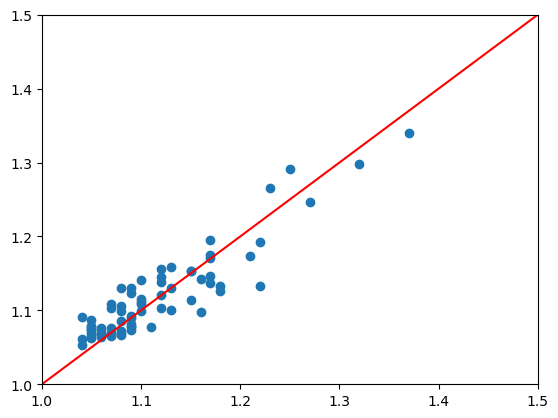

In [22]:
plt.scatter(y_test, y_pred)
plt.ylim(1, 1.5)
plt.xlim(1, 1.5)
x = np.linspace(0,2,20)
y = np.linspace(0,2,20)
plt.plot(x, y, color = 'red')
plt.savefig('../../figures/tti-pred')

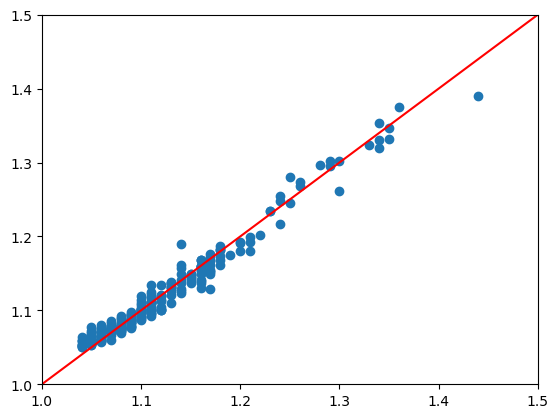

In [23]:
y_pred_train = rf.predict(X_train)
plt.scatter(y_train, y_pred_train)
plt.ylim(1, 1.5)
plt.xlim(1, 1.5)
x = np.linspace(0,2,20)
y = np.linspace(0,2,20)
plt.plot(x, y, color = 'red')

In [24]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
tree_importances = pd.Series(result.importances_mean, index=X.columns)

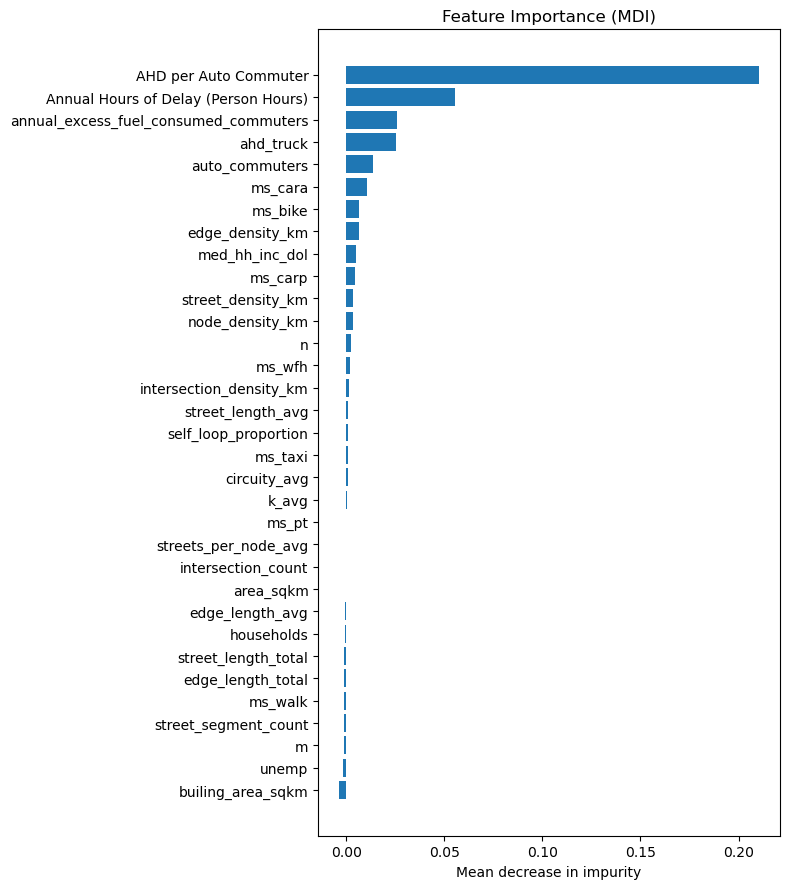

In [25]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

plt.figure(figsize=(8,9))
# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");
plt.tight_layout()
plt.savefig('../../figures/tti-rf.png',dpi=300)

In [26]:
rfc = RandomForestRegressor(max_features= 'log2', n_estimators=700, random_state=0, max_depth = 4 ) #ccp_alpha=0.1
A = df.drop(columns=['ahd', ])
B = (df['ahd'])
A_train, A_test, b_train, b_test = train_test_split(A, B, test_size = .2, random_state = 1)
rfc.fit(A_train, b_train)
b_pred = rfc.predict(A_test)
b_pred

KeyError: "['ahd'] not found in axis"

In [ ]:
mse = mean_squared_error(b_test, b_pred)
mape = mean_absolute_percentage_error(b_test, b_pred)
rmse = np.sqrt(mean_squared_error(b_test, b_pred))
print(f'mse = {mse} mape = {mape} rmse = {rmse}')

In [ ]:
param_grid = { 
    'n_estimators': [100, 200,300, 400, 500, 600, 700],
    'max_features': [3, 5, 9, 12, 'sqrt', 'log2'],
    'max_depth' : [2, 3, 4,5,6,7,8, 9, 10, 11],   
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(A_train, b_train)
CV_rfc.best_params_

In [ ]:
plt.scatter(b_test, b_pred)
plt.ylim(0,40000)
plt.xlim(0, 40000)
x = np.linspace(0,40000,20)
y = np.linspace(0,40000,20)
plt.plot(x, y, color = 'red')
plt.savefig('../../figures/ahd_pred')

In [ ]:
result = permutation_importance(
    rfc, A_test, b_test, n_repeats=10, random_state=42, n_jobs=2)
tree_importances = pd.Series(result.importances_mean, index=X.columns)

In [ ]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

plt.figure(figsize=(8,9))
# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(A.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");
plt.tight_layout()
plt.savefig('../../figures/ahd-rf.png',dpi=300)